# Project 1 Using Yelp reviews to predict a business's stars rating based on all the reviews for that business using fully-connected neural network implementations in TensorFlow. Consider this problem as a regression problem.
## Alexei Godfray 9/17/2025

### Importing packages and. checking versions

In [1]:
import tensorflow as tf
import numpy as np
import sys
import sklearn as sk
import pandas as pd

print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))
print("Keras Version: {}".format(tf.keras.__version__))

Python 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 08:43:59) [Clang 18.1.8 ]
Pandas 2.3.2
Numpy 2.0.1
Scikit-Learn 1.7.2

Tensor Flow Version: 2.20.0
Keras Version: 3.11.3


## Dataset
### https://www.yelp.com/dataset
#### Download unzip and put this dataset in your root project directory

#### Import the data from json

In [2]:
review = pd.read_json('./yelp_dataset/yelp_academic_dataset_review.json', lines=True, nrows = 3000000)
business = pd.read_json('./yelp_dataset/yelp_academic_dataset_business.json', lines=True, nrows = 3000000)

In [3]:
review.shape

(3000000, 9)

In [4]:
business.shape

(150346, 14)

## So it looks like our data is being Dected and formated Correctly
### However, we need to do a few things 
* In this project, we will only consider the businesses with at least 20 reviews
* required to split data to training and test. Use training data to train your models and evaluate the model quality using test data.


### Below is the code that is for getting rid of business with less than 20 review_count

In [5]:
def business_filter(business, rev_count = 20):
    business_filtered = business[business['review_count'] >= rev_count]
    return business_filtered
business_filtered = business_filter(business, rev_count = 20)
business_filtered

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150330,GeEveoOaU2YKD7jJtEfA_g,DeVons Jewelers,"13981 S Virginia St, 402A",Reno,NV,89511,39.404552,-119.750986,5.0,34,1,"{'BusinessParking': '{'garage': False, 'street...","Shopping, Watches, Jewelry","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
150331,qQ7FHvkGEMqoPKKXPk4gjA,La Quinta by Wyndham NW Tucson Marana,6020 West Hospitality Rd,Tucson,AZ,85743,32.358587,-111.093308,2.5,67,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Hotels & Travel, Hotels, Event Planning & Serv...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
150334,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,"1638 Pine St, Fl 1",Philadelphia,PA,19103,39.945966,-75.169666,4.5,39,1,"{'ByAppointmentOnly': 'True', 'GoodForKids': '...","Health & Medical, Yoga, Shopping, Naturopathic...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
150336,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


# Aggregation of the Reviews to the business using Pandas 
## We want to match business_id of review to business_id of business
### This will then subtract the rows that don't have business ids 

In [6]:
def merge_review_business(business_filtered, review):
    df = pd.merge(business_filtered, review, on='business_id', how='inner')
    df_review_agg = df.groupby('business_id')['text'].sum()
    df_review_agg = df_review_agg.reset_index()
    df_full = pd.merge(business_filtered, df_review_agg, on='business_id', how='inner')
    return df_full
df_review_agg = merge_review_business(business_filtered, review)
df_review_agg.rename(columns={'text':'all_reviews'}, inplace=True)
df_cleaned = df_review_agg[['business_id', 'name', 'stars', 'all_reviews']]
df_cleaned

,business_id,name,stars,all_reviews
0,tUFrWirKiKi_TAnsVWINQQ,Target,3.5,We are fans of Target. They seem to have a li...
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,This is nice little Chinese bakery in the hear...
2,il_Ro8jwPlHresjw9EGmBg,Denny's,2.5,Went there at 4am and there was only one waitr...
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,4.5,The worst Chicken Parm. Sandwich I've ever eat...
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,4.0,Stopped in to check out this new spot around t...
...,...,...,...,...
30224,3XzvT-SaEpx8Dun_Jv2LLw,SixFour Growlers,4.5,How did it take so long for Reno to get a fill...
30225,aJB-yCUFV1fREG7-Z1J5Zw,Tooley's Cafe,3.5,When a friend called and invited me to eat at ...
30226,G9LUtsVsB_K0ONdHWL1caQ,Edmonton Downtown Farmers Market,4.5,I really love the City Centre Market! Unlike t...
30227,-ZTGyVZiVlKr36jnpM6xFA,Mercedes-Benz of Cherry Hill,2.5,I'm giving three stars to give the dealership ...


# Now we split the Data
## around a 80 / 20 split 

In [7]:
from sklearn.model_selection import train_test_split
x = df_cleaned['all_reviews'].astype(str).values
y = df_cleaned['stars'].astype(np.float32).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
y_train

array([4.5, 4. , 3. , ..., 2. , 3. , 1.5], dtype=float32)

# Now that we slpit the Data we can start the TF-IDF Process 
### we will use the sklearn library to generate the vectors 

In [8]:
import sklearn.feature_extraction.text as sk_text
tfidf_vectorizer = sk_text.TfidfVectorizer(max_features=1000, stop_words='english', min_df=1)

matrix_train = tfidf_vectorizer.fit_transform(x_train)
matrix_test = tfidf_vectorizer.transform(x_test)

print(type(matrix_train)) 
print(matrix_train.toarray())

<class 'scipy.sparse._csr.csr_matrix'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02402059 0.0430265  0.         ... 0.01600801 0.         0.00842931]
 [0.02564354 0.0172251  0.         ... 0.         0.         0.02699651]
 ...
 [0.         0.01693355 0.         ... 0.         0.         0.        ]
 [0.02082071 0.         0.         ... 0.         0.         0.        ]
 [0.01286749 0.03553341 0.00892215 ... 0.00857527 0.         0.        ]]


In [9]:
print(tfidf_vectorizer.get_feature_names_out())

['00' '10' '100' '11' '12' '15' '20' '25' '30' '40' '45' '50' 'able'
 'absolutely' 'accommodating' 'actually' 'add' 'added' 'addition'
 'affordable' 'afternoon' 'ago' 'ahead' 'air' 'airport' 'amazing'
 'ambiance' 'american' 'app' 'apparently' 'appetizer' 'appetizers'
 'appointment' 'appreciate' 'area' 'aren' 'arrived' 'asian' 'ask' 'asked'
 'asking' 'ate' 'atmosphere' 'attention' 'attentive' 'attitude'
 'authentic' 'available' 'average' 'avocado' 'avoid' 'away' 'awesome'
 'awful' 'bacon' 'bad' 'bag' 'baked' 'bar' 'barbara' 'barely' 'bartender'
 'bartenders' 'based' 'basic' 'basically' 'bathroom' 'bbq' 'beach' 'beans'
 'beat' 'beautiful' 'bed' 'beef' 'beer' 'beers' 'believe' 'best' 'better'
 'big' 'birthday' 'bit' 'bite' 'black' 'bland' 'blue' 'book' 'bottle'
 'bought' 'bowl' 'box' 'boy' 'boyfriend' 'bread' 'breakfast' 'bring'
 'brisket' 'broth' 'brought' 'brown' 'brunch' 'buffet' 'building' 'bun'
 'burger' 'burgers' 'burrito' 'business' 'busy' 'butter' 'buy' 'cafe'
 'cake' 'cakes' 'cal

In [10]:
tfidf_data = matrix_train.toarray()
tfidf_data_test = matrix_test.toarray()

tfidf_data
tfidf_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02402059, 0.0430265 , 0.        , ..., 0.01600801, 0.        ,
        0.00842931],
       [0.02564354, 0.0172251 , 0.        , ..., 0.        , 0.        ,
        0.02699651],
       ...,
       [0.        , 0.01693355, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02082071, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01286749, 0.03553341, 0.00892215, ..., 0.00857527, 0.        ,
        0.        ]])

# Now that we have out text Processed, then Vectorized, we can then start the training process using TensorFlow 
### We will be using a fully-connected neural network and this is a regression problem 
### We will use reviews to predict the star rating of a buisness 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()

input_dim = tfidf_data.shape[1]

model.add(Dense(25, input_dim=input_dim, activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError()])

history = model.fit(tfidf_data,y_train,verbose=2,epochs=300, validation_data=(tfidf_data_test, y_test))

/opt/homebrew/anaconda3/envs/tf-py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
756/756 - 1s - 2ms/step - loss: 0.8894 - root_mean_squared_error: 0.9431 - val_loss: 0.1850 - val_root_mean_squared_error: 0.4301
Epoch 2/300
756/756 - 1s - 710us/step - loss: 0.1563 - root_mean_squared_error: 0.3954 - val_loss: 0.1408 - val_root_mean_squared_error: 0.3753
Epoch 3/300
756/756 - 1s - 703us/step - loss: 0.1315 - root_mean_squared_error: 0.3627 - val_loss: 0.1296 - val_root_mean_squared_error: 0.3600
Epoch 4/300
756/756 - 1s - 688us/step - loss: 0.1234 - root_mean_squared_error: 0.3513 - val_loss: 0.1268 - val_root_mean_squared_error: 0.3560
Epoch 5/300
756/756 - 1s - 804us/step - loss: 0.1174 - root_mean_squared_error: 0.3427 - val_loss: 0.1240 - val_root_mean_squared_error: 0.3522
Epoch 6/300
756/756 - 1s - 828us/step - loss: 0.1080 - root_mean_squared_error: 0.3287 - val_loss: 0.1181 - val_root_mean_squared_error: 0.3437
Epoch 7/300
756/756 - 1s - 713us/step - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.1175 - val_root_mean_squared_error: 0

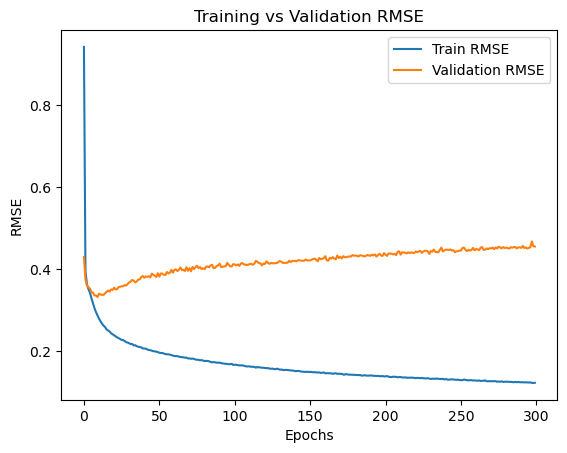

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Used the trained model to make regression predictions 

In [13]:
pred = model.predict(tfidf_data_test)
print("Shape: {}".format(pred.shape))
print(pred)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
Shape: (6046, 1)
[[3.1379774]
 [1.9330013]
 [2.0400372]
 ...
 [4.3976502]
 [3.9398196]
 [3.0145843]]


## RMSE of the result

In [14]:
from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.45540198070629806


# Lets just print out the the prediction 

In [15]:
import pandas as pd
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,3.5,3.137977
1,4.0,1.933001
2,1.5,2.040037
3,2.0,1.444572
4,3.5,3.277002
...,...,...
6041,5.0,5.036108
6042,4.0,4.038414
6043,4.0,4.397650
6044,4.0,3.939820


# So the model is off, lets fix this! 
### maybe try diffrent:
* techniques
* optimizers 
* activation functions
* neuron layers

### Lets try to change the max-features to be lrger so we can have some rarer words show up, this may help

In [16]:
tfidf_vectorizer = sk_text.TfidfVectorizer(
    stop_words='english',
    max_features=600, 
    min_df=1,           
    ngram_range=(1, 2)  
)

matrix_train = tfidf_vectorizer.fit_transform(x_train)
matrix_test = tfidf_vectorizer.transform(x_test)

print(type(matrix_train)) 
print(matrix_train.toarray())

<class 'scipy.sparse._csr.csr_matrix'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02469173 0.04422867 0.00777843 ... 0.00736128 0.         0.00866483]
 [0.02667593 0.01791856 0.         ... 0.02385847 0.         0.02808337]
 ...
 [0.         0.01801363 0.02534422 ... 0.         0.02272456 0.        ]
 [0.02312947 0.         0.         ... 0.         0.         0.        ]
 [0.01433727 0.03959219 0.01505517 ... 0.01424778 0.01484892 0.        ]]


In [17]:
print(tfidf_vectorizer.get_feature_names_out())

['00' '10' '12' '15' '20' '30' '50' 'able' 'absolutely' 'actually' 'add'
 'added' 'ago' 'amazing' 'ambiance' 'appetizer' 'appetizers' 'appointment'
 'area' 'arrived' 'ask' 'asked' 'ate' 'atmosphere' 'attentive' 'authentic'
 'available' 'average' 'away' 'awesome' 'bacon' 'bad' 'bar' 'bartender'
 'based' 'bbq' 'beans' 'beautiful' 'beef' 'beer' 'beers' 'believe' 'best'
 'better' 'big' 'birthday' 'bit' 'bite' 'black' 'bland' 'bowl' 'boyfriend'
 'bread' 'breakfast' 'bring' 'brought' 'brunch' 'burger' 'burgers'
 'business' 'busy' 'butter' 'buy' 'cafe' 'cake' 'called' 'came' 'car'
 'card' 'care' 'change' 'charge' 'cheap' 'check' 'cheese' 'chef' 'chicken'
 'chinese' 'chips' 'chocolate' 'choice' 'choices' 'choose' 'city' 'clean'
 'close' 'coffee' 'cold' 'come' 'comes' 'comfortable' 'coming' 'company'
 'completely' 'cooked' 'cool' 'cost' 'couldn' 'counter' 'couple' 'course'
 'crab' 'cream' 'crispy' 'crowded' 'crust' 'cup' 'customer'
 'customer service' 'customers' 'cut' 'cute' 'date' 'day' 'days

In [18]:
tfidf_data = matrix_train.toarray()
tfidf_data_test = matrix_test.toarray()

tfidf_data
tfidf_data_test

array([[0.        , 0.03812358, 0.        , ..., 0.        , 0.01603123,
        0.        ],
       [0.        , 0.04052051, 0.        , ..., 0.        , 0.20446982,
        0.        ],
       [0.        , 0.06129298, 0.021559  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02701696, 0.01900572, ..., 0.        , 0.        ,
        0.02117154],
       [0.00822619, 0.02210255, 0.0194357 , ..., 0.        , 0.02439747,
        0.        ],
       [0.        , 0.0207015 , 0.02912592, ..., 0.01378197, 0.03264422,
        0.        ]])

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
input_dim = tfidf_data.shape[1]

model.add(Dense(120, activation='relu',input_dim=input_dim, kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(1))  # regression output

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[RootMeanSquaredError()]  
)

early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',  
    patience=10,
    min_delta=1e-4,
    mode='min',
    restore_best_weights=True               
)

checkpointer = ModelCheckpoint(
    filepath="best_model.keras",
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=0
)

history = model.fit(
    tfidf_data, y_train,
    validation_data=(tfidf_data_test, y_test),
    epochs=1000,
    batch_size=256,          # tweakable
    shuffle=True,
    callbacks=[early_stop, checkpointer],
    verbose=2
)

Epoch 1/1000


/opt/homebrew/anaconda3/envs/tf-py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


95/95 - 1s - 9ms/step - loss: 2.9576 - root_mean_squared_error: 1.7113 - val_loss: 0.6235 - val_root_mean_squared_error: 0.7708
Epoch 2/1000
95/95 - 0s - 3ms/step - loss: 0.3790 - root_mean_squared_error: 0.5912 - val_loss: 0.2682 - val_root_mean_squared_error: 0.4890
Epoch 3/1000
95/95 - 0s - 3ms/step - loss: 0.2311 - root_mean_squared_error: 0.4499 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4156
Epoch 4/1000
95/95 - 0s - 3ms/step - loss: 0.1827 - root_mean_squared_error: 0.3940 - val_loss: 0.1696 - val_root_mean_squared_error: 0.3777
Epoch 5/1000
95/95 - 0s - 3ms/step - loss: 0.1616 - root_mean_squared_error: 0.3677 - val_loss: 0.1583 - val_root_mean_squared_error: 0.3639
Epoch 6/1000
95/95 - 0s - 3ms/step - loss: 0.1518 - root_mean_squared_error: 0.3557 - val_loss: 0.1520 - val_root_mean_squared_error: 0.3566
Epoch 7/1000
95/95 - 0s - 3ms/step - loss: 0.1433 - root_mean_squared_error: 0.3448 - val_loss: 0.1446 - val_root_mean_squared_error: 0.3471
Epoch 8/1000
95/95 - 0s - 

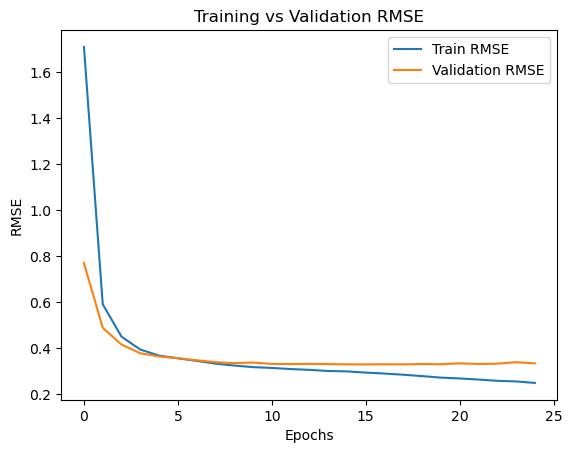

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [42]:
pred = model.predict(tfidf_data_test)
print("Shape: {}".format(pred.shape))
print(pred)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
Shape: (6046, 1)
[[3.6528559]
 [2.4256268]
 [2.1220481]
 ...
 [4.2753024]
 [3.968821 ]
 [2.8242583]]


In [43]:
from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.3295194988769174


In [39]:
import pandas as pd
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred.round(1)],axis=1)
result[0:20]

,ground_truth,predicted
0,3.5,3.7
1,4.0,2.6
2,1.5,2.1
3,2.0,2.2
4,3.5,3.5
5,2.5,2.5
6,2.0,1.9
7,3.5,3.8
8,4.5,4.8
9,4.5,4.6


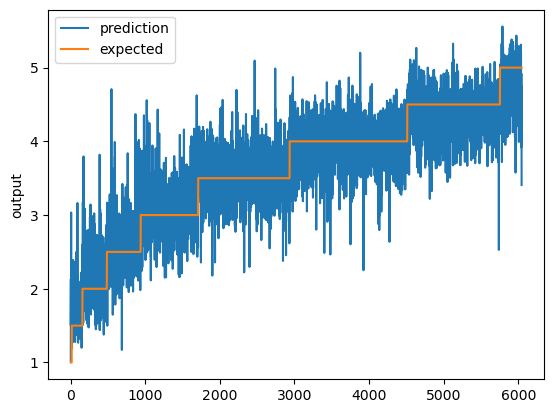

In [24]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()


%matplotlib inline
from matplotlib.pyplot import figure, show

chart_regression(pred.flatten(),y_test)

# Another attempt to fix the model

In [25]:
model = Sequential()

input_dim = tfidf_data.shape[1]

model.add(Dense(64, input_dim=input_dim, activation='sigmoid')) # Hidden 1
model.add(Dense(25, activation='sigmoid'))
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=[RootMeanSquaredError()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights.keras", verbose=0, save_best_only=True)

history = model.fit(tfidf_data, y_train, validation_data=(tfidf_data_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)  

Epoch 1/1000


/opt/homebrew/anaconda3/envs/tf-py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


756/756 - 1s - 1ms/step - loss: 0.7334 - root_mean_squared_error: 0.8564 - val_loss: 0.6951 - val_root_mean_squared_error: 0.8337
Epoch 2/1000
756/756 - 1s - 742us/step - loss: 0.6925 - root_mean_squared_error: 0.8321 - val_loss: 0.6884 - val_root_mean_squared_error: 0.8297
Epoch 3/1000
756/756 - 1s - 741us/step - loss: 0.6858 - root_mean_squared_error: 0.8281 - val_loss: 0.6815 - val_root_mean_squared_error: 0.8255
Epoch 4/1000
756/756 - 1s - 774us/step - loss: 0.6777 - root_mean_squared_error: 0.8232 - val_loss: 0.6822 - val_root_mean_squared_error: 0.8260
Epoch 5/1000
756/756 - 1s - 785us/step - loss: 0.6673 - root_mean_squared_error: 0.8169 - val_loss: 0.6579 - val_root_mean_squared_error: 0.8111
Epoch 6/1000
756/756 - 1s - 753us/step - loss: 0.6496 - root_mean_squared_error: 0.8060 - val_loss: 0.6389 - val_root_mean_squared_error: 0.7993
Epoch 7/1000
756/756 - 1s - 757us/step - loss: 0.6238 - root_mean_squared_error: 0.7898 - val_loss: 0.6042 - val_root_mean_squared_error: 0.7773


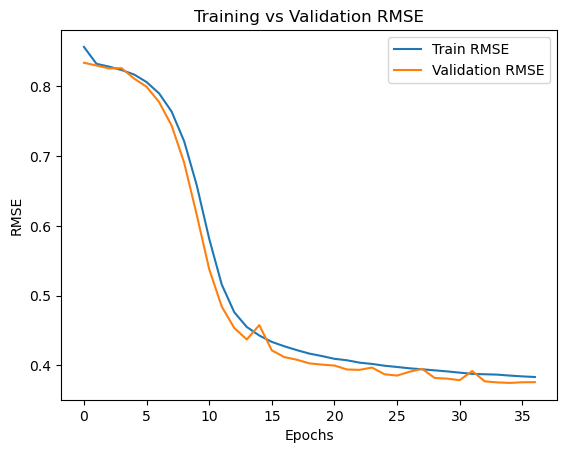

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [27]:
pred = model.predict(tfidf_data_test)
print("Shape: {}".format(pred.shape))
print(pred)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
Shape: (6046, 1)
[[3.7598016]
 [2.7389822]
 [1.9324617]
 ...
 [4.388339 ]
 [3.668245 ]
 [2.9662998]]


In [28]:
from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.37596964643978875


In [29]:
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred.round(1)],axis=1)
result[0:5]

,ground_truth,predicted
0,3.5,3.8
1,4.0,2.7
2,1.5,1.9
3,2.0,2.6
4,3.5,3.7


In [30]:
model = Sequential()

input_dim = tfidf_data.shape[1]

model.add(Dense(64, input_dim=input_dim, activation='tanh')) # Hidden 1
model.add(Dense(25, activation='tanh'))
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='SGD')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights.keras", verbose=0, save_best_only=True)

model.fit(tfidf_data, y_train, validation_data=(tfidf_data_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)  

Epoch 1/1000


/opt/homebrew/anaconda3/envs/tf-py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


756/756 - 1s - 931us/step - loss: 0.3919 - val_loss: 0.1849
Epoch 2/1000
756/756 - 1s - 757us/step - loss: 0.1746 - val_loss: 0.1544
Epoch 3/1000
756/756 - 0s - 640us/step - loss: 0.1590 - val_loss: 0.1459
Epoch 4/1000
756/756 - 0s - 631us/step - loss: 0.1512 - val_loss: 0.1420
Epoch 5/1000
756/756 - 1s - 1ms/step - loss: 0.1462 - val_loss: 0.1370
Epoch 6/1000
756/756 - 0s - 637us/step - loss: 0.1426 - val_loss: 0.1357
Epoch 7/1000
756/756 - 1s - 667us/step - loss: 0.1404 - val_loss: 0.1337
Epoch 8/1000
756/756 - 1s - 810us/step - loss: 0.1386 - val_loss: 0.1333
Epoch 9/1000
756/756 - 1s - 748us/step - loss: 0.1372 - val_loss: 0.1317
Epoch 10/1000
756/756 - 1s - 759us/step - loss: 0.1362 - val_loss: 0.1314
Epoch 11/1000
756/756 - 0s - 645us/step - loss: 0.1354 - val_loss: 0.1316
Epoch 12/1000
756/756 - 0s - 620us/step - loss: 0.1343 - val_loss: 0.1312
Epoch 12: early stopping


In [31]:
pred = model.predict(tfidf_data_test)
print("Shape: {}".format(pred.shape))
print(pred)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
Shape: (6046, 1)
[[3.5914886]
 [2.7036111]
 [2.0792854]
 ...
 [4.2872643]
 [3.7043324]
 [2.9771605]]


In [32]:
from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.36219133932927405


In [33]:
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred.round(1)],axis=1)
result[0:5]

,ground_truth,predicted
0,3.5,3.6
1,4.0,2.7
2,1.5,2.1
3,2.0,2.6
4,3.5,3.6
